In [1]:
import os 
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import time
import random
from pprint import pprint
from glob import glob

import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2
from matplotlib.patches import FancyArrowPatch

import pyrender

import pygarment as pyg
import trimesh
import PIL
from PIL import Image

from analysis_utils import plot_panel_info, set_constants

DATASET_ROOT = set_constants()

GARMENT_ROOT_PATH = os.path.join(DATASET_ROOT, "GarmentCodeData_v2")
BODY_ROOT_PATH = os.path.join(DATASET_ROOT, "body_mesh")
MEAN_ALL_BODY_PATH = os.path.join(DATASET_ROOT, "neutral_body/mean_all.obj")

BODY_TYPE = "default_body"

garment_path_list = sorted(list(filter(
    os.path.isdir,
    glob(os.path.join(GARMENT_ROOT_PATH, "*", BODY_TYPE, "*"))
)))
print(len(garment_path_list))

132670


In [101]:
from tqdm import tqdm

whole_bbox_list = []
for garment_path in tqdm(garment_path_list):
    garment_id = os.path.basename(garment_path)
    SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json")
    pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

    panel_svg_path_dict = {
        panel_name : pattern._draw_a_panel(
            panel_name, apply_transform=False, fill=True
        )
        for panel_name in pattern.panel_order()
    }
    for panel_name, panel in panel_svg_path_dict.items():
        path = panel[0]
        x1, x2, y1, y2 = path.bbox()
        whole_bbox_list.append([x1, x2, y1, y2])

whole_bbox_arr = np.array(whole_bbox_list)


100%|██████████| 132670/132670 [05:02<00:00, 438.77it/s]


In [102]:
with open("whole_bbox_arr.pkl", "wb") as f:
    pickle.dump(whole_bbox_arr, f)


In [79]:
# from tqdm import tqdm

# panel_word_list = []
# for garment_path in tqdm(garment_path_list):
#     garment_id = os.path.basename(garment_path)
#     SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json")
#     pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

#     panel_svg_path_dict = {
#         panel_name : pattern._draw_a_panel(
#             panel_name, apply_transform=False, fill=True
#         )
#         for panel_name in pattern.panel_order()
#     }
#     for panel_name, panel in panel_svg_path_dict.items():
#         print(panel_name.split("_"))
        
#     break


# bbox_list = np.array(bbox_list)


In [103]:
print(
    np.stack([
        whole_bbox_arr[:, 1] - whole_bbox_arr[:, 0],
        whole_bbox_arr[:, 3] - whole_bbox_arr[:, 2]
    ]).max(axis=1)
)

print(
    np.stack([
        whole_bbox_arr[:, 1] - whole_bbox_arr[:, 0],
        whole_bbox_arr[:, 3] - whole_bbox_arr[:, 2]
    ]).min(axis=1)
)

[640.71998589 243.86567961]
[2.70720227 0.14011207]


In [107]:
print(
    (
        (whole_bbox_arr[:, 1] - whole_bbox_arr[:, 0]) / (whole_bbox_arr[:, 3] - whole_bbox_arr[:, 2])
    ).min()
)
print(
    (
        (whole_bbox_arr[:, 1] - whole_bbox_arr[:, 0]) / (whole_bbox_arr[:, 3] - whole_bbox_arr[:, 2])
    ).max()
)

0.10198366856191583
150.33728406126815


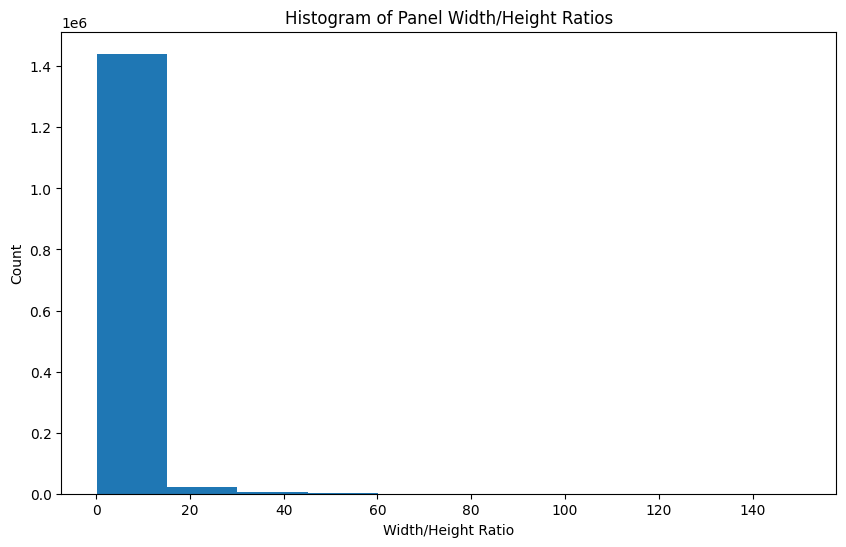

In [109]:

plt.figure(figsize=(10, 6))
plt.hist(
    (whole_bbox_arr[:, 1] - whole_bbox_arr[:, 0]) / (whole_bbox_arr[:, 3] - whole_bbox_arr[:, 2]),
    bins=10
)
plt.xlabel('Width/Height Ratio')
plt.ylabel('Count')
plt.title('Histogram of Panel Width/Height Ratios')
plt.show()

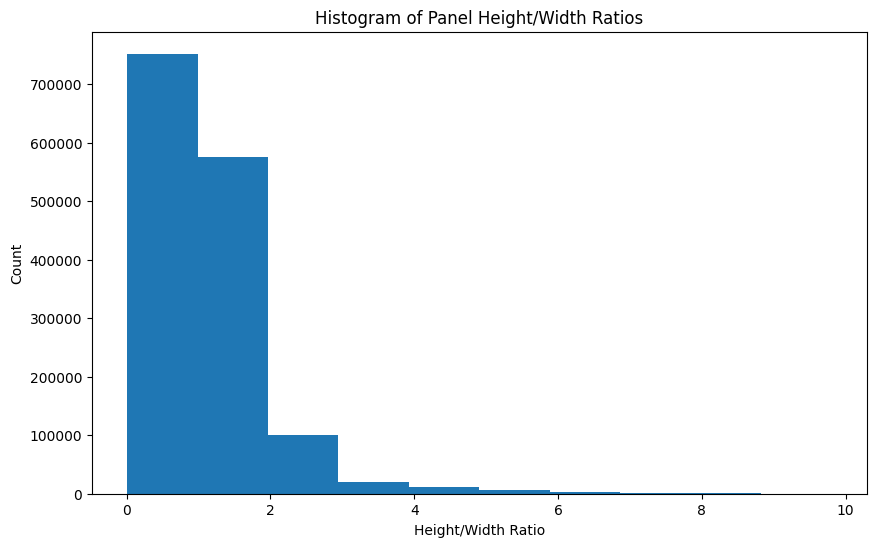

In [113]:

plt.figure(figsize=(10, 6))
plt.hist(
    (whole_bbox_arr[:, 3] - whole_bbox_arr[:, 2]) / (whole_bbox_arr[:, 1] - whole_bbox_arr[:, 0]),
    bins=10
)
plt.xlabel('Height/Width Ratio')
plt.ylabel('Count')
plt.title('Histogram of Panel Height/Width Ratios')
plt.show()

In [120]:
stt_edge_to_longest_edge_ratio_list_whole = []
stt_edge_to_shortest_edge_ratio_list_whole = []


# IDX = 0

# IDX = random.randint(0, len(garment_path_list) - 1)

# garment_path = garment_path_list[IDX]
for garment_path in tqdm(garment_path_list):
    garment_id = os.path.basename(garment_path)
    SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json")
    pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

    # Get Garment Blueprint
    panel_svg_path_dict = {
        panel_name : pattern._draw_a_panel(
            panel_name, apply_transform=False, fill=True
        )
        for panel_name in pattern.panel_order()
    }
    stitch_dict = {
        i : v for i, v in enumerate(pattern.pattern['stitches'])
    }

    FIGLEN = 4
    NCOLS = int(np.sqrt(len(panel_svg_path_dict)))
    NROWS = int(np.ceil(len(panel_svg_path_dict) / NCOLS))


    garment_bbox_list = []
    stt_edge_to_longest_edge_ratio_list = []
    stt_edge_to_shortest_edge_ratio_list = []
    
    # plt.figure(figsize=(FIGLEN * NCOLS, FIGLEN * NROWS))
    for i, (panel_name, panel) in enumerate(panel_svg_path_dict.items()):
        x1, x2, y1, y2 = panel[0].bbox()
        garment_bbox_list.append([x2 - x1, y2 - y1])
        w, h = x2 - x1, y2 - y1
        
        path = panel[0]
        
        edge_len_list = []
        for edge_idx, edge in enumerate(path):
            if edge_idx == 0 :
                stt_edge_length = edge.length()
            edge_length = edge.length()
            edge_len_list.append(edge_length)
            
        stt_edge_to_longest_edge_ratio_list.append(
            max(edge_len_list) / stt_edge_length
        )
        stt_edge_to_shortest_edge_ratio_list.append(
            min(edge_len_list) / stt_edge_length 
        )

    stt_edge_to_longest_edge_ratio_list_whole.append(
        np.array(stt_edge_to_longest_edge_ratio_list).max()
    )
    stt_edge_to_shortest_edge_ratio_list_whole.append(
        np.array(stt_edge_to_shortest_edge_ratio_list).min()
    )

    # print(np.array(stt_edge_to_longest_edge_ratio_list).min())
    # print(np.array(stt_edge_to_shortest_edge_ratio_list).max())


100%|██████████| 132670/132670 [08:57<00:00, 246.74it/s]


In [121]:
with open("stt_edge_to_longest_edge_ratio_list_whole.pkl", "wb") as f:
    pickle.dump(stt_edge_to_longest_edge_ratio_list_whole, f)
with open("stt_edge_to_shortest_edge_ratio_list_whole.pkl", "wb") as f:
    pickle.dump(stt_edge_to_shortest_edge_ratio_list_whole, f)


In [123]:
print(np.array(stt_edge_to_longest_edge_ratio_list_whole).max())
print(np.array(stt_edge_to_shortest_edge_ratio_list_whole).min())


5873.327414472275
0.00015655038641086233


In [124]:
filtered_garment_path_list = []

stt_edge_to_longest_edge_ratio_list_whole = []
stt_edge_to_shortest_edge_ratio_list_whole = []

THRES = 10
for garment_path in tqdm(garment_path_list):
    garment_id = os.path.basename(garment_path)
    SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json")
    pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

    # Get Garment Blueprint
    panel_svg_path_dict = {
        panel_name : pattern._draw_a_panel(
            panel_name, apply_transform=False, fill=True
        )
        for panel_name in pattern.panel_order()
    }
    stitch_dict = {
        i : v for i, v in enumerate(pattern.pattern['stitches'])
    }

    FIGLEN = 4
    NCOLS = int(np.sqrt(len(panel_svg_path_dict)))
    NROWS = int(np.ceil(len(panel_svg_path_dict) / NCOLS))

    garment_bbox_list = []
    stt_edge_to_longest_edge_ratio_list = []
    stt_edge_to_shortest_edge_ratio_list = []
    
    for i, (panel_name, panel) in enumerate(panel_svg_path_dict.items()):
        x1, x2, y1, y2 = panel[0].bbox()
        garment_bbox_list.append([x2 - x1, y2 - y1])
        w, h = x2 - x1, y2 - y1
        
        path = panel[0]
        
        edge_len_list = []
        for edge_idx, edge in enumerate(path):
            if edge_idx == 0 :
                stt_edge_length = edge.length()
            edge_length = edge.length()
            edge_len_list.append(edge_length)
            
        stt_edge_to_longest_edge_ratio_list.append(
            max(edge_len_list) / stt_edge_length
        )
        stt_edge_to_shortest_edge_ratio_list.append(
            min(edge_len_list) / stt_edge_length 
        )
        
        if (
            max(edge_len_list) / stt_edge_length < THRES
        ) or (
            stt_edge_length / min(edge_len_list) > THRES
        ): 
            continue
        filtered_garment_path_list.append(garment_path)

    stt_edge_to_longest_edge_ratio_list_whole.append(
        np.array(stt_edge_to_longest_edge_ratio_list).max()
    )
    stt_edge_to_shortest_edge_ratio_list_whole.append(
        np.array(stt_edge_to_shortest_edge_ratio_list).min()
    )

    # print(np.array(stt_edge_to_longest_edge_ratio_list).min())
    # print(np.array(stt_edge_to_shortest_edge_ratio_list).max())


100%|██████████| 132670/132670 [08:59<00:00, 245.74it/s]


In [125]:
print(len(filtered_garment_path_list))


63572


In [126]:
with open("filtered_garment_path_list.pkl", "wb") as f:
    pickle.dump(filtered_garment_path_list, f)


In [129]:
thres = 30

filtered_garment_path_list_2 = []

for garment_path in tqdm(garment_path_list):
    garment_id = os.path.basename(garment_path)
    SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json")
    pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

    # Get Garment Blueprint
    panel_svg_path_dict = {
        panel_name : pattern._draw_a_panel(
            panel_name, apply_transform=False, fill=True
        )
        for panel_name in pattern.panel_order()
    }
    stitch_dict = {
        i : v for i, v in enumerate(pattern.pattern['stitches'])
    }
    
    for panel_name, panel in panel_svg_path_dict.items():
        path = panel[0]
        
        first_edge_length = 0
        is_valid = True
        for edge_idx, edge in enumerate(path):
            if edge_idx == 0 :
                first_edge_length = edge.length()
            edge_length = edge.length()
            if edge_length / first_edge_length > thres :
                # print(garment_path)
                # print(panel_name)
                is_valid = False
                break
            if edge_length / first_edge_length < (1 / thres) :
                # print(garment_path)
                # print(panel_name)
                is_valid = False
                break
        if is_valid :
            filtered_garment_path_list_2.append(garment_path)

print(len(filtered_garment_path_list_2))

with open("filtered_garment_path_list_2.pkl", "wb") as f:
    pickle.dump(filtered_garment_path_list_2, f)
        

100%|██████████| 132670/132670 [05:54<00:00, 374.18it/s]

1323411


In [72]:
import svgpathtools


IDX = random.randint(0, len(garment_path_list) - 1)

garment_path = garment_path_list[IDX]

garment_path = '/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_30/default_body/rand_2W0IYY409L'

garment_id = os.path.basename(garment_path)
SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json")
pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

# Get Garment Blueprint
panel_svg_path_dict = {
    panel_name : pattern._draw_a_panel(
        panel_name, apply_transform=False, fill=True
    )
    for panel_name in pattern.panel_order()
}
stitch_dict = {
    i : v for i, v in enumerate(pattern.pattern['stitches'])
}



for panel_name, panel in panel_svg_path_dict.items():
    path = panel[0]
    
    for edge_idx, edge in enumerate(path):
        # print(type(edge), edge)
        if isinstance(edge, svgpathtools.path.Arc):
            print(edge.start, edge.end)
    

In [75]:
type(path)

svgpathtools.path.Path

In [134]:
mandatory_token_count = 0
for panel_name, panel in panel_svg_path_dict.items():
    mandatory_token_count += 10
    path = panel[0]
    for edge_idx, edge in enumerate(path):
        mandatory_token_count += 3
mandatory_token_count

328

250


/tmp/ipykernel_1656360/3798781072.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


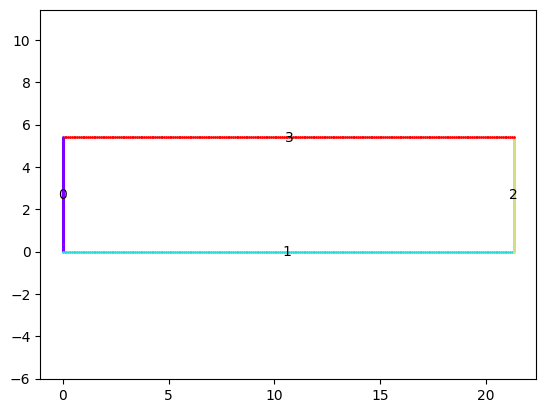

250


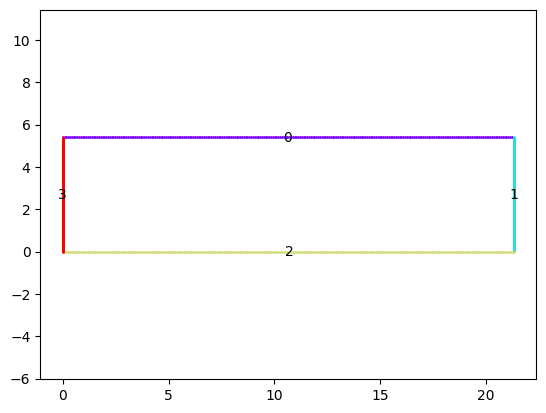

200


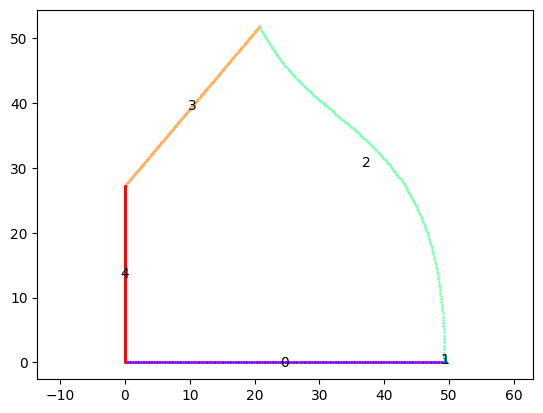

250


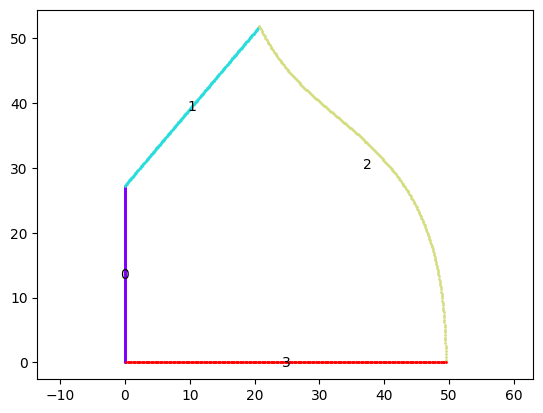

125


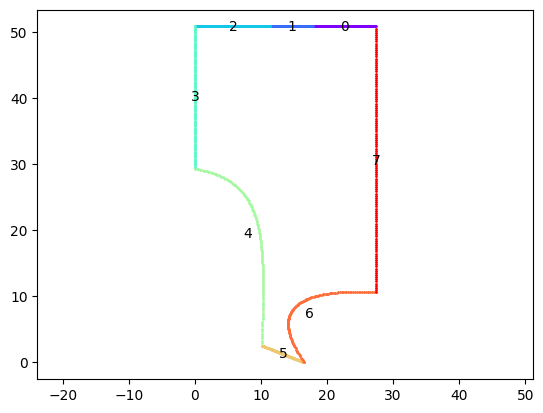

125


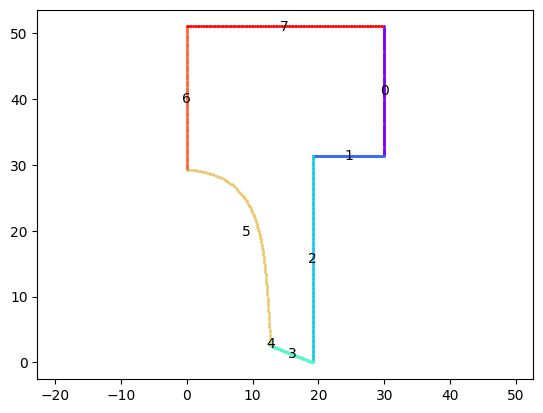

45


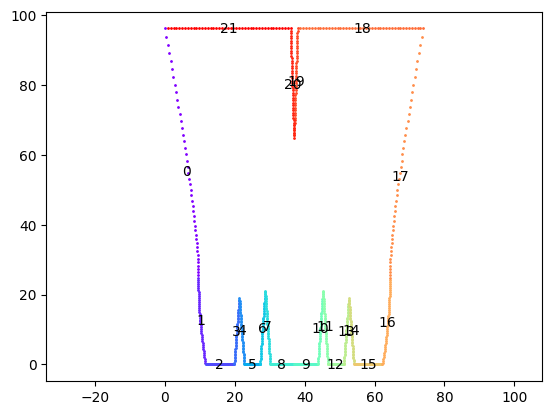

142


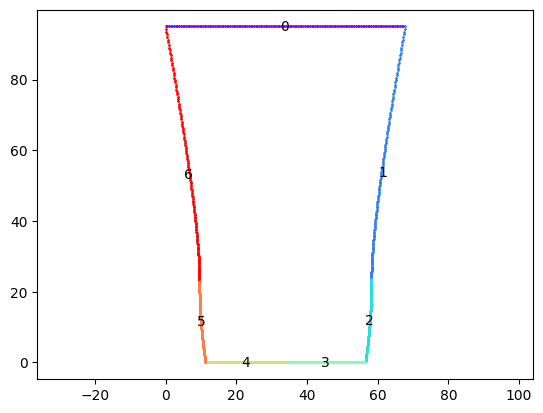

125


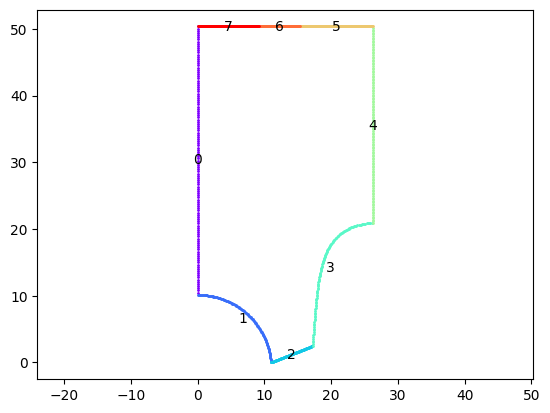

166


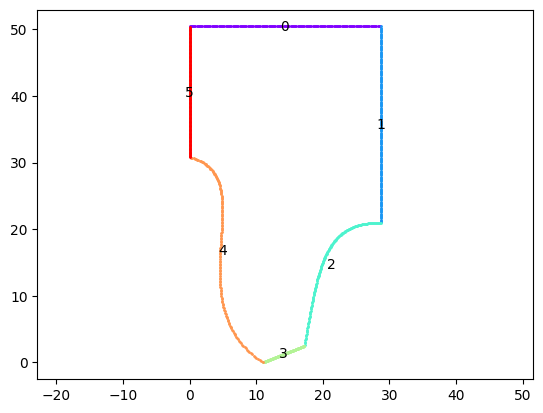

In [130]:
for panel_name, panel in panel_svg_path_dict.items():
    path = panel[0]
    
    x1, x2, y1, y2 = path.bbox()
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    l = max(x2 - x1, y2 - y1)
    
    N_SAMPLES_PER_EDGE = 1000 // len(path)
    print(N_SAMPLES_PER_EDGE)
    
    image = np.ones((1000, 1000, 3), dtype=np.uint8) * 255
    
    color_list = plt.cm.rainbow(np.linspace(0, 1, len(path)))
    edge_sampled_point_arr_list = []
    for edge_idx, edge in enumerate(path):
        edge_sampled_point_arr_list.append(
            np.array([
                [edge.point(t).real, edge.point(t).imag]
                for t in np.linspace(0, 1, N_SAMPLES_PER_EDGE)[:-1]
            ])
        )
        plt.annotate(
            f"{edge_idx}",
            edge_sampled_point_arr_list[-1].mean(axis=0),
            ha='center', va='center'
        )
        plt.scatter(
            edge_sampled_point_arr_list[-1][:, 0],
            edge_sampled_point_arr_list[-1][:, 1],
            c=color_list[edge_idx],
            s=1
        )
    plt.axis('equal')
    plt.show()

In [10]:
len(path)

4